# Bayesian Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# !pip3 install torchvision

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
# from scipy.misc import imread

In [4]:
from tqdm.notebook import tqdm

In [5]:
%matplotlib inline

In [36]:
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        
        # Fully connected layer from 28x28=784 (image shape) to 1024 (hidden layer)
        self.fc1 = nn.Linear(input_size, hidden_size)
        
        # Fully connected from 1024 to 10 (MNIST classes)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        
        # OBS: There is no softmax bc we want the probability to each class
        output = self.out(output)
        return output

In [9]:
# Download MNIST data
train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashion-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashion-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [10]:
# Initialize pytorch network
net = NN(28*28, 1024, 10)

In [11]:
# !pip3 install pyro-ppl

In [12]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [13]:
log_softmax = nn.LogSoftmax(dim=1)

In [14]:
# Pyro will transform weights and biases from our network to random variables
# Since our network has two layers, we need to assign priors to each of the weights of both layers

In [15]:
def model(x_data, y_data):
    
    # Normal prior for the first layer
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    # Normal prior for the hidden layer
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 
              'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 
              'out.bias': outb_prior}
    
    # Here the transformation to random variables ocurs: net->priors
    # TODO: Change this since it is deprecated to pyro.nn.PyroModule?
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    
    # Apply softmax to get the highest probability class
    lhat = log_softmax(lifted_reg_model(x_data))
    
    # Here we are telling Pyro that the output is categorical (since we are classifying images in 10 classes)
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [16]:
# We need to define the inference model
# That is, we retrieve the original parameters of the model in order to be able to modify them while training
# Training = guessing the posterior distribution

softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [17]:
# Optimizer: Adam with learning rate 
optim = Adam({"lr": 0.01})

# SVI: Stochastic Variational Inference
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [18]:
def train_model(num_iterations = 20, early_stopping=True):
   
    # Keep losses to display learning curve
    loss_curve_train = []
    loss_curve_test = []

    # Early stopping when a epoch of overfitting occurs
    if early_stopping:
        print("Train max of {} iterations with early-stopping".format(num_iterations))
    tbar = tqdm(range(num_iterations))
    try:
        for j in tbar:
            
            loss = 0   # Train loss
            losst = 0  # Test loss
            
            for batch_id, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc="Feeding train"):
                # calculate the loss and take a gradient step
                loss += svi.step(data[0].view(-1,28*28), data[1])

            for batch_id, data in tqdm(enumerate(test_loader), total=len(test_loader), leave=False, desc="Feeding test"):
                # calculate the loss and take a gradient step
                losst += svi.step(data[0].view(-1,28*28), data[1])


            # Mean of the losses of the baches
            total_epoch_loss_train, total_epoch_loss_test = loss/len(train_loader), losst/len(test_loader)

            # Check early-stopping
            if (j > 0) and (total_epoch_loss_test > loss_curve_test[-1]) and early_stopping:
                print("Early stopping")
                raise KeyboardInterrupt

            # If it is not overfitting yet, append losses to the learning curves
            loss_curve_train.append(total_epoch_loss_train)
            loss_curve_test.append(total_epoch_loss_test)

            # Update train and test in the progress bar
            tbar.set_description("Train: {:4.3f} | Test: {:4.3f}".format(total_epoch_loss_train, total_epoch_loss_test))
        return loss_curve_train, loss_curve_test

    except KeyboardInterrupt:
        print("Stopped at epoch {}".format(j))
        return loss_curve_train, loss_curve_test

In [19]:
next(iter(train_loader))[0].view(-1,28*28).shape

torch.Size([128, 784])

In [20]:
loss_curve_train, loss_curve_test = train_model()

Train max of 20 iterations with early-stopping


/usr/local/lib/python3.7/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Early stopping
Stopped at epoch 8


In [22]:
detail_from_ep = 3

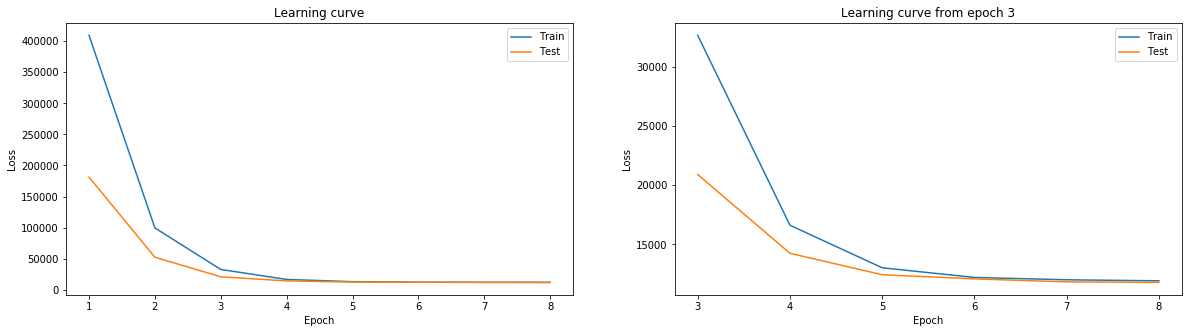

In [23]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)

ax.plot(range(1, len(loss_curve_train)+1), loss_curve_train, label="Train")
ax.plot(range(1, len(loss_curve_train)+1), loss_curve_test, label = "Test")
ax.legend()
ax.set_xticks(range(1, len(loss_curve_train)+1))

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.set_title("Learning curve")

ax = fig.add_subplot(122)

ax.plot(range(detail_from_ep, len(loss_curve_train)+1), loss_curve_train[detail_from_ep-1:], label="Train")
ax.plot(range(detail_from_ep, len(loss_curve_train)+1), loss_curve_test[detail_from_ep-1:], label = "Test")
ax.legend()
ax.set_xticks(range(detail_from_ep, len(loss_curve_train)+1))

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.set_title("Learning curve from epoch {}".format(detail_from_ep))

plt.show()

In [25]:
num_samples = 10

# Predict a class for a given input

# Notice in the predict() function is that we’re using the learned guide() 
# function (and not the model() function) to do predictions. This is because for model(), 
# all we know is priors for weights and not the posterior
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    mx = np.argmax(mean.numpy(), axis=1)
    return mx

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in tqdm(enumerate(test_loader), total=len(test_loader)):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
#     print(list(zip(predicted, labels.cpu().numpy())))
    correct += (predicted == labels.cpu().numpy()).sum().item()
#     break
print("accuracy: {:5.3f}%".format(100 * correct / total))

Prediction when network is forced to predict



accuracy: 73.910%


In [26]:
classes = [str(i) for i in range(10)]

In [27]:
def imshow(img, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if not ax:
        fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    if not ax:
        plt.show()

In [28]:
num_samples = 100

def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1, 28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [29]:
def test_batch(images, labels, threshold=0.2):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in tqdm(range(len(labels))):
        fig, axs = plt.subplots(1, 11, figsize=(30,3))
        
        all_digits_prob = []
        highted_something = False
    
        imshow(images[i].squeeze(), ax=axs[0])
        for j in range(len(classes)):
            highlight=False
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>threshold): #select if network thinks this sample is XX% chance of this being a label
                highlight = True # possibly an answer
        
            all_digits_prob.append(prob)
                        
            N, bins, patches = axs[j+1].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
            axs[j+1].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                

                # We'll color code by height, but you could use any scalar
                fracs = N / N.max()

                # we need to normalize the data to 0..1 for the full range of the colormap
                norm = colors.Normalize(fracs.min(), fracs.max())

                # Now, we'll loop through our objects and set the color of each accordingly
                for thisfrac, thispatch in zip(fracs, patches):
                    color = plt.cm.viridis(norm(thisfrac))
                    thispatch.set_facecolor(color)

    
        predicted = np.argmax(all_digits_prob)
        real = labels[i].item()
        
        if(highted_something):
            predicted_for_images+=1
            
            if(real==predicted):
                axs[0].set_title("Correct: {}".format(real))
                correct_predictions +=1.0
            else:
                axs[0].set_title("Incorrect: {} | Real {}".format(predicted, real))
        else:
            axs[0].set_title("Undecided | Real {}".format(real))
            
        plt.tight_layout()
        plt.show()
        
    print("Summary")
    print("Total images: ",len(labels))
    print("Predicted for: ",predicted_for_images)
    print("Accuracy when predicted: {}/{}".format(correct_predictions,predicted_for_images))
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [30]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

### Test in real images

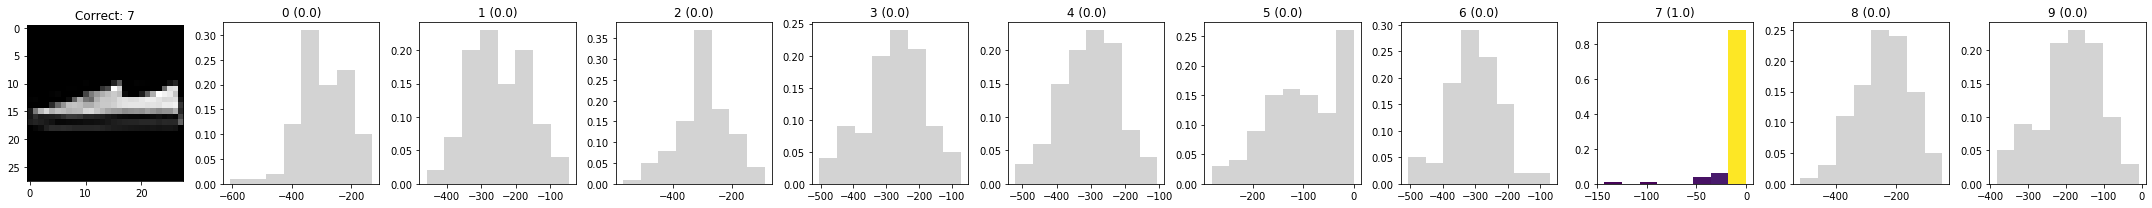

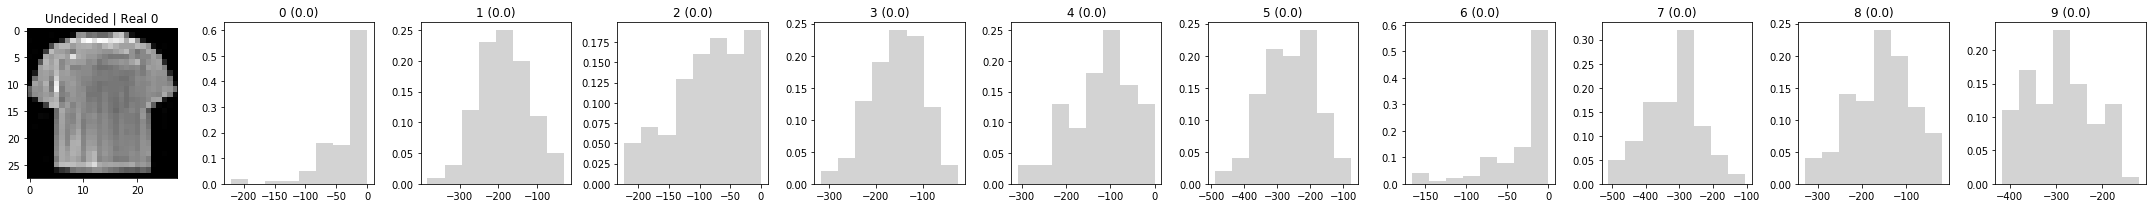

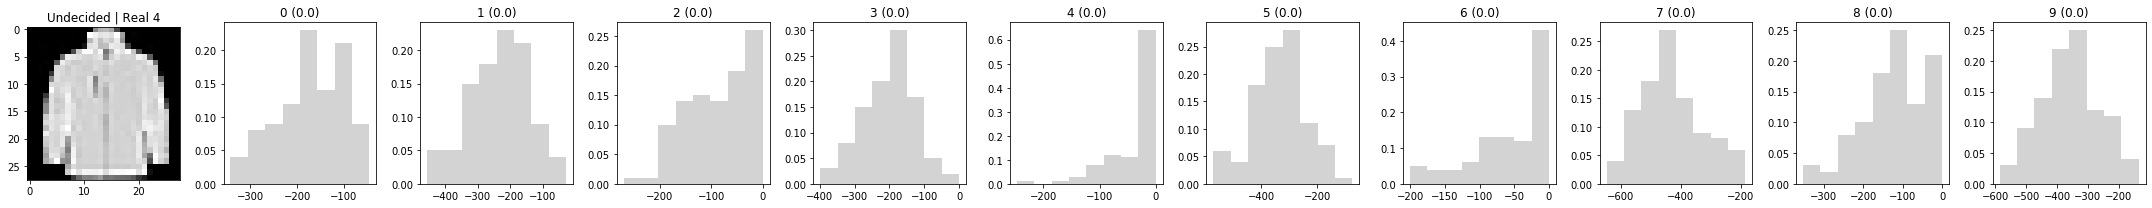

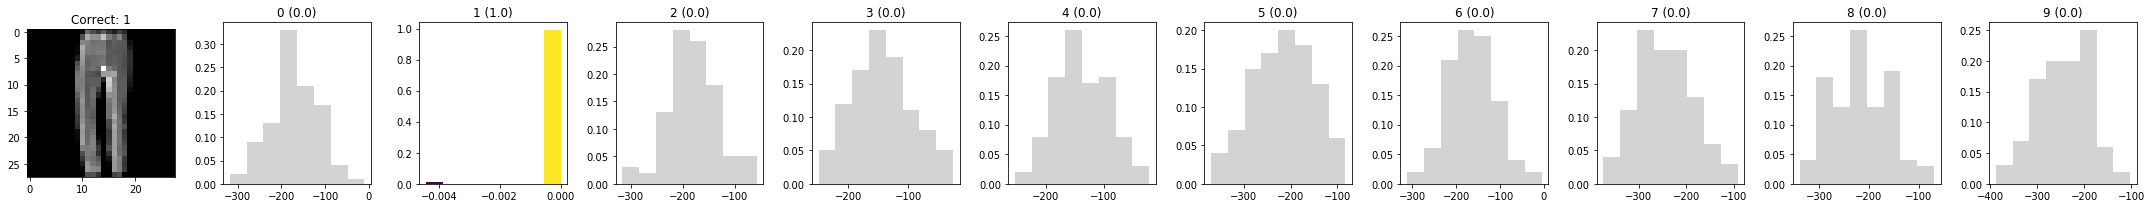

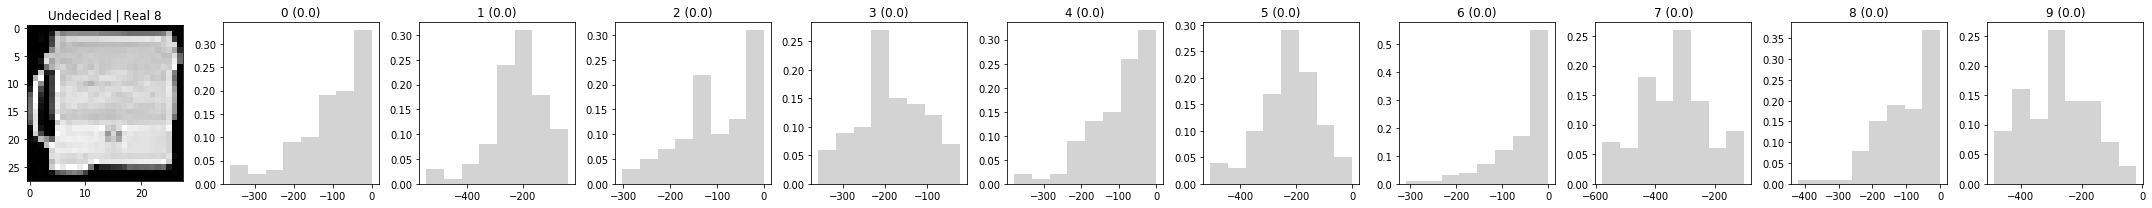

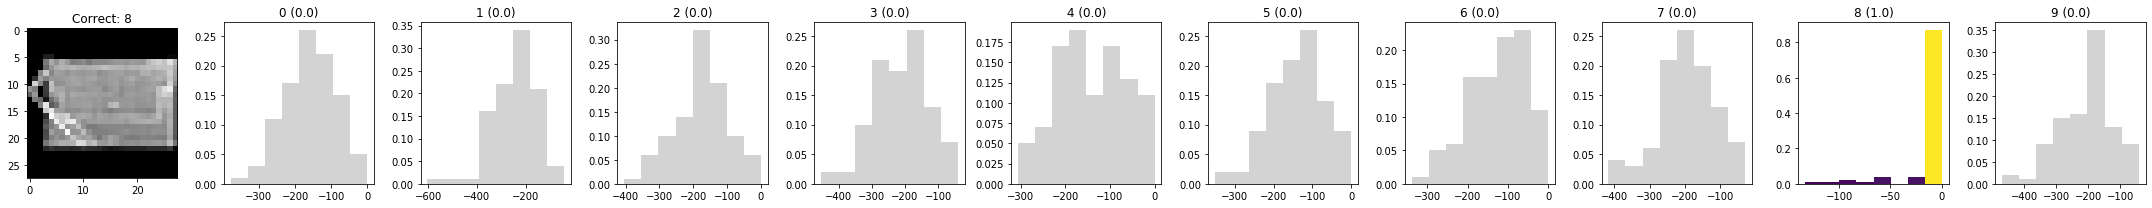

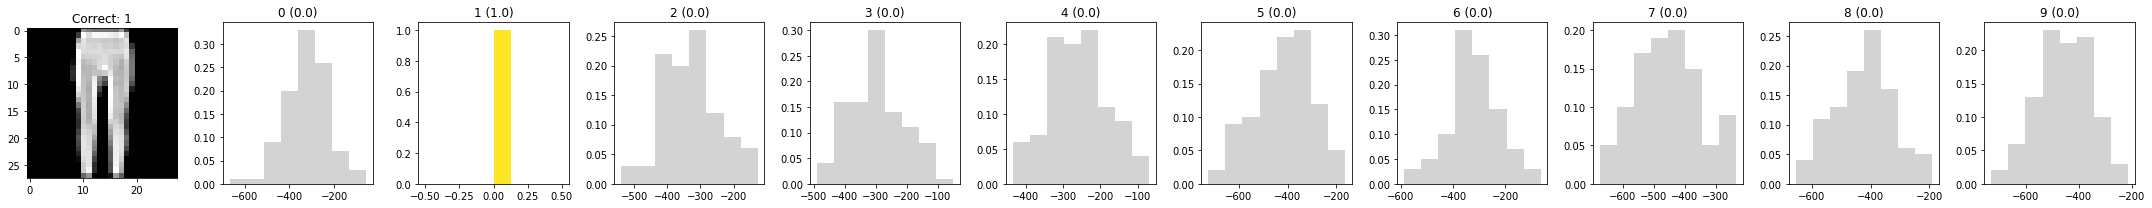

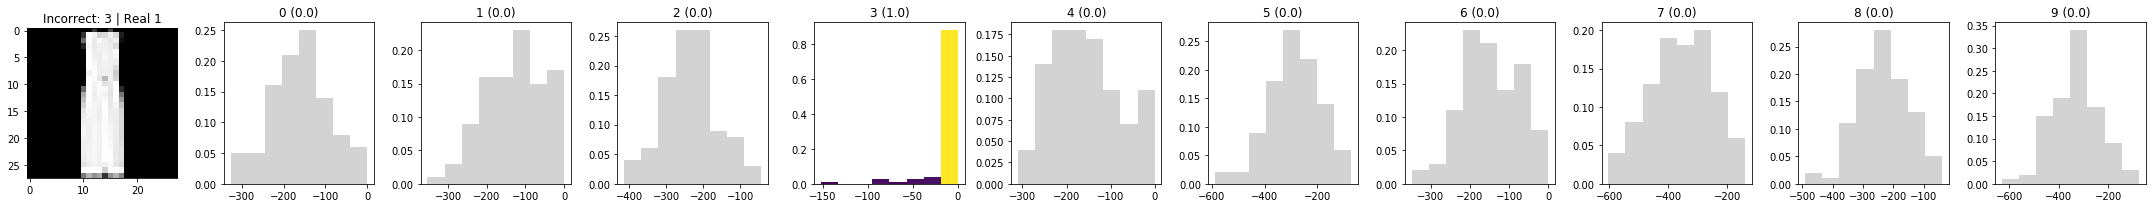

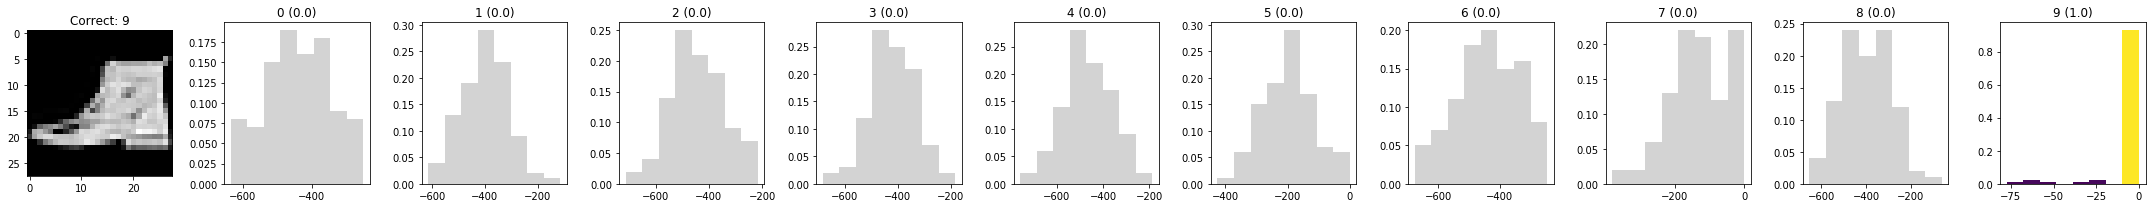

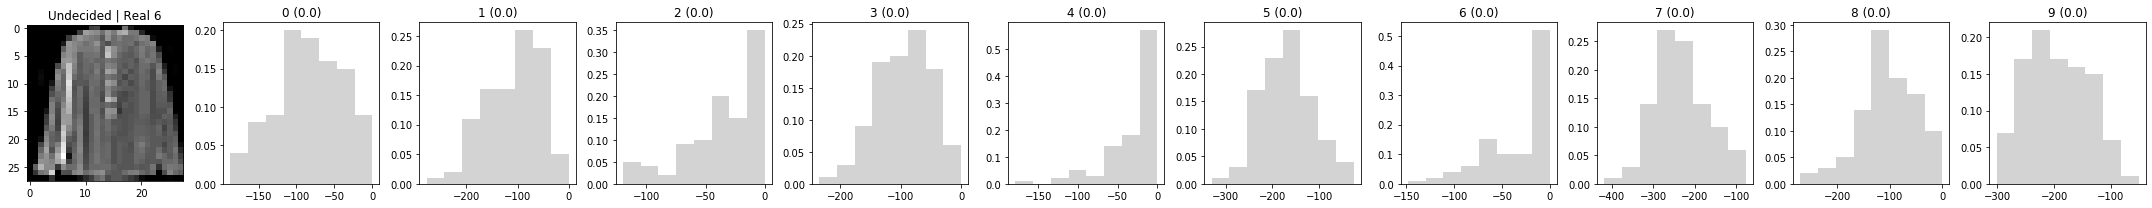


Summary
Total images:  10
Predicted for:  6
Accuracy when predicted: 5.0/6


(10, 5.0, 6)

In [31]:
N = 10
rds = np.random.randint(128, size=N)
test_batch(images[rds], labels[rds])

### Test in noisy images

In [32]:
# generate random data

images_random = torch.rand(5,28,28)
labels_random = torch.randint(0,10, (5,))

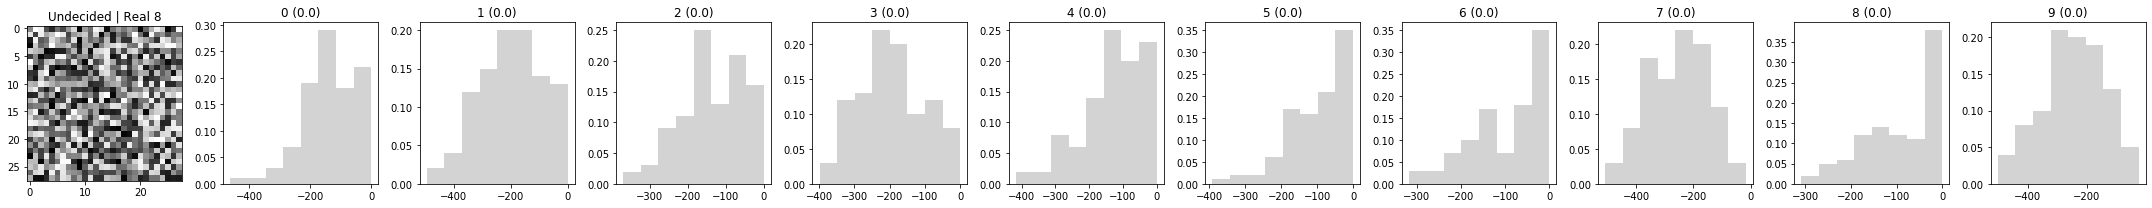

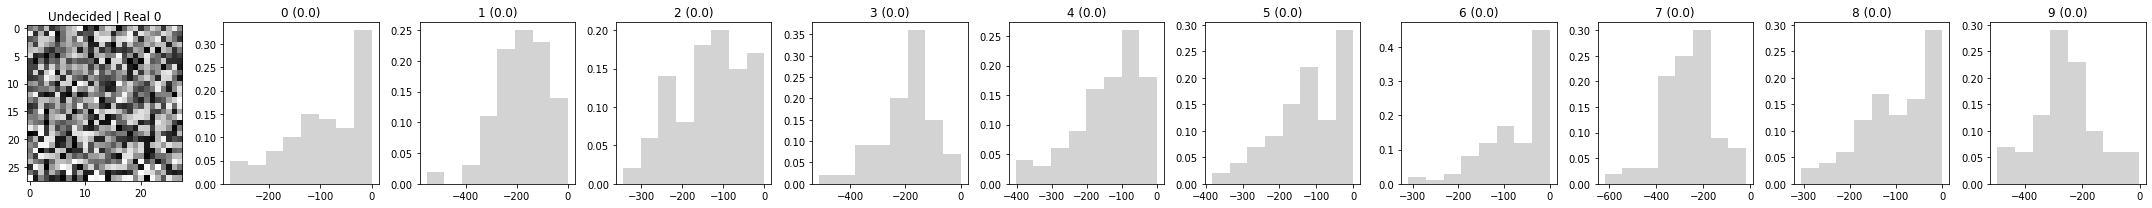

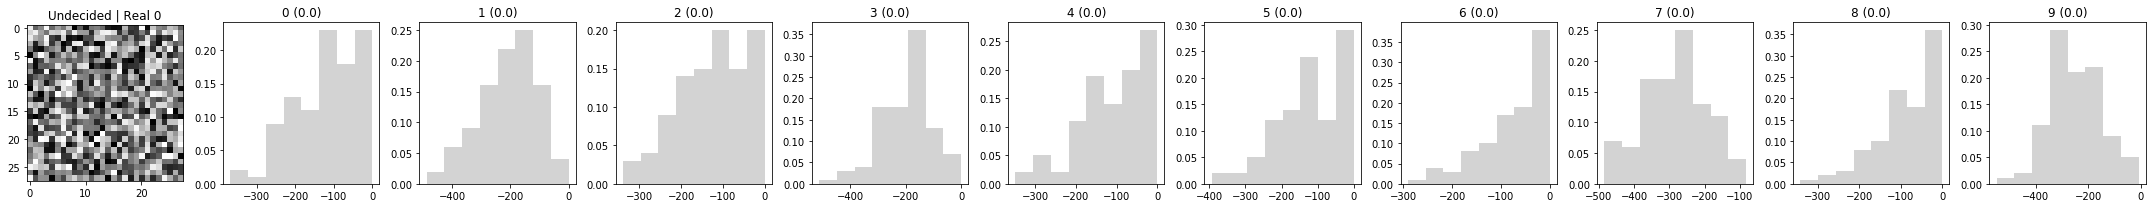

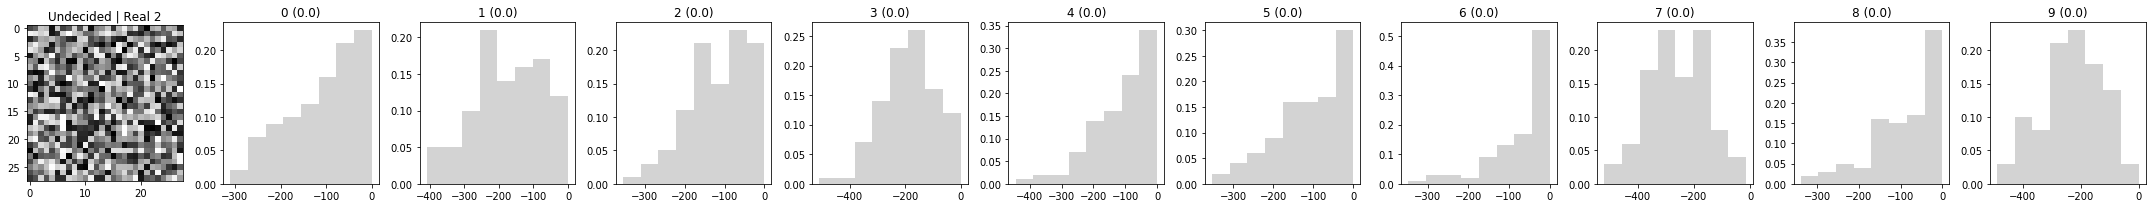

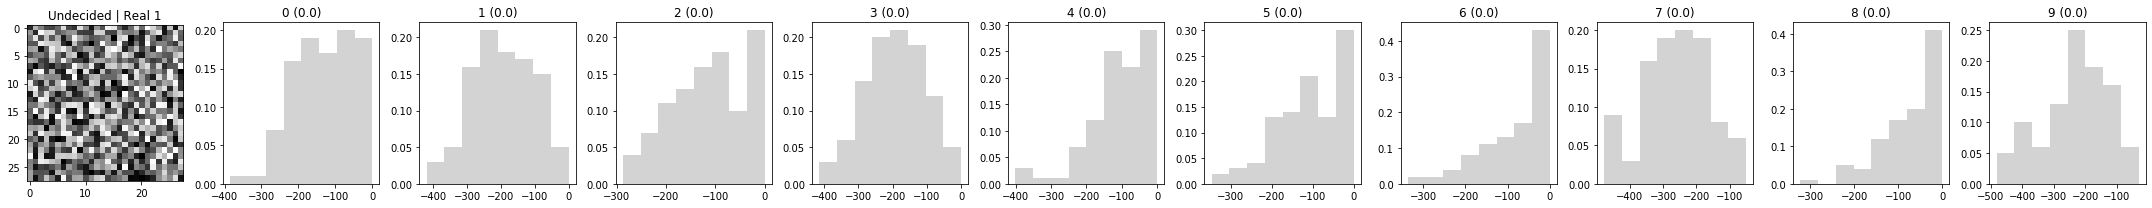


Summary
Total images:  5
Predicted for:  0
Accuracy when predicted: 0/0


(5, 0, 0)

In [33]:
test_batch(images_random, labels_random)

### Test in sum of two real images

They are dupliacted since there are two 'real' labels

In [34]:
N=5

rand1, rand2 = np.random.randint(len(labels), size=N-1), np.random.randint(len(labels), size=N)

r1, r2 = np.random.randint(len(labels)), np.random.randint(len(labels))

sum_imgs = torch.max(images[r1],images[r2])
sum_imgs = torch.cat([sum_imgs, torch.max(images[r1],images[r2])], dim=0)

sum_labs = [labels[r1].numpy(), labels[r1].numpy()]
for r1, r2 in zip(rand1, rand2):
    sum_imgs = torch.cat([sum_imgs, torch.max(images[r1],images[r2])], dim=0)    
    sum_imgs = torch.cat([sum_imgs, torch.max(images[r1],images[r2])], dim=0)
    
    sum_labs += [labels[r1].numpy()]
    sum_labs += [labels[r2].numpy()]
    
sum_labs = torch.stack([torch.tensor(s) for s in sum_labs], dim=0)

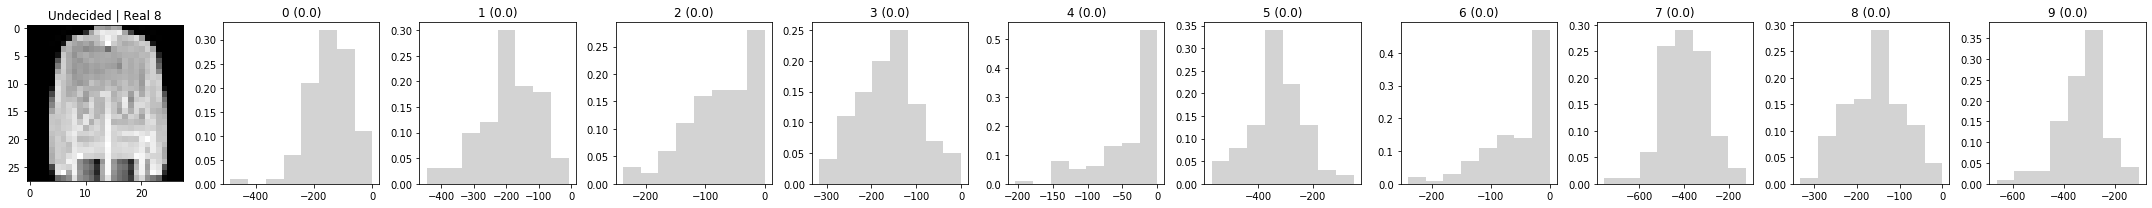

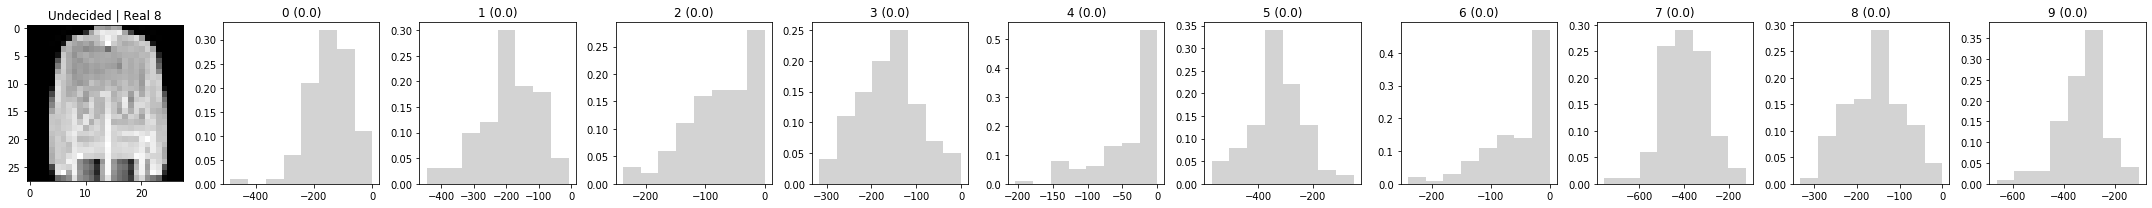

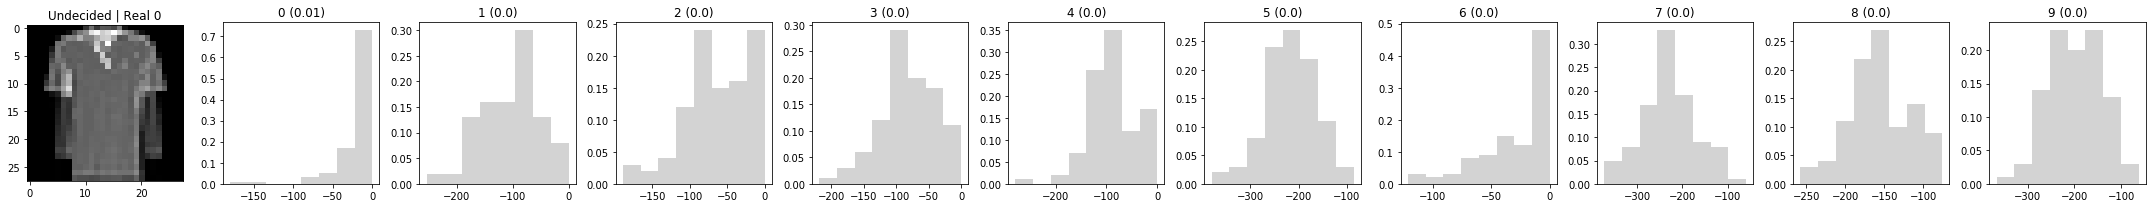

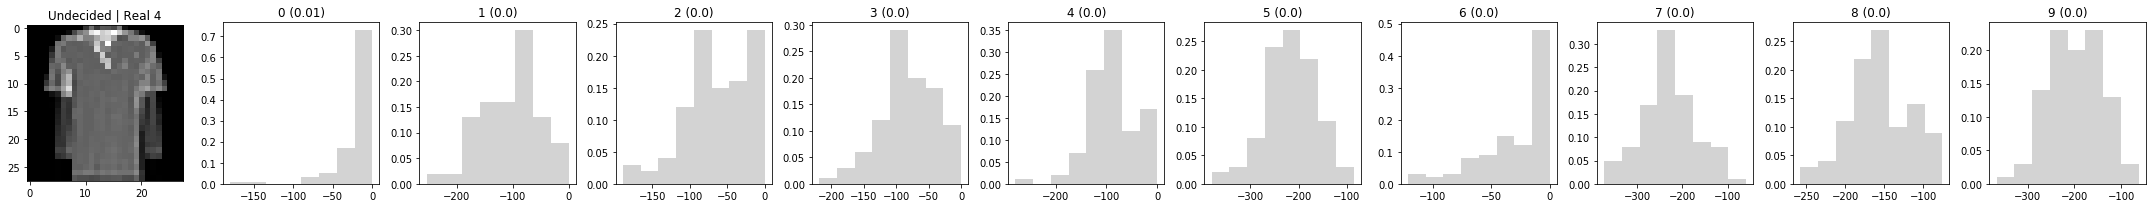

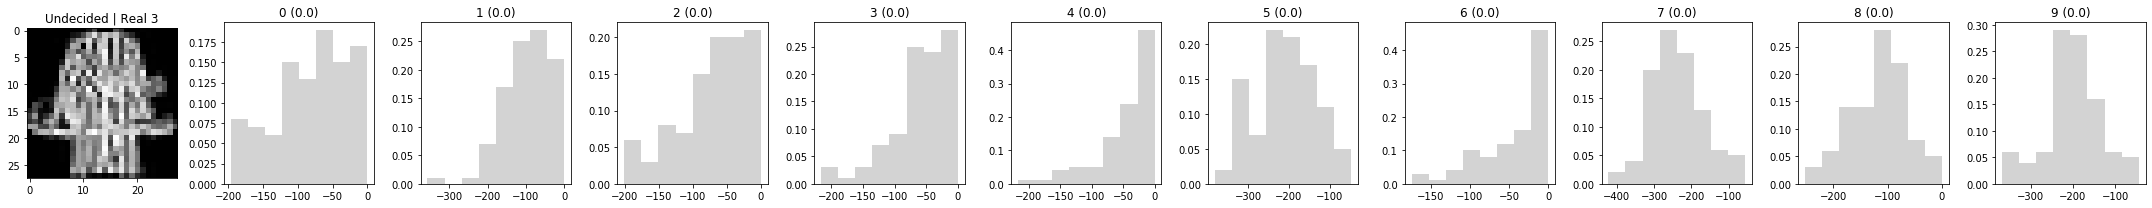

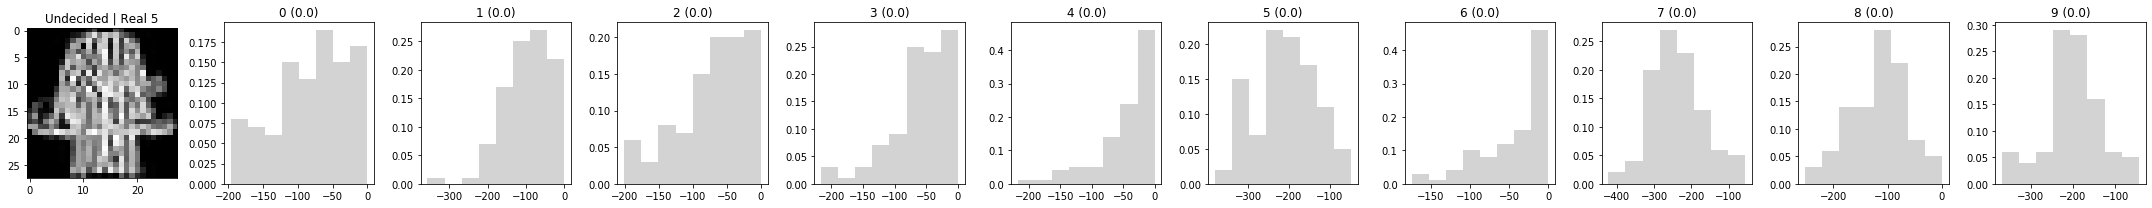

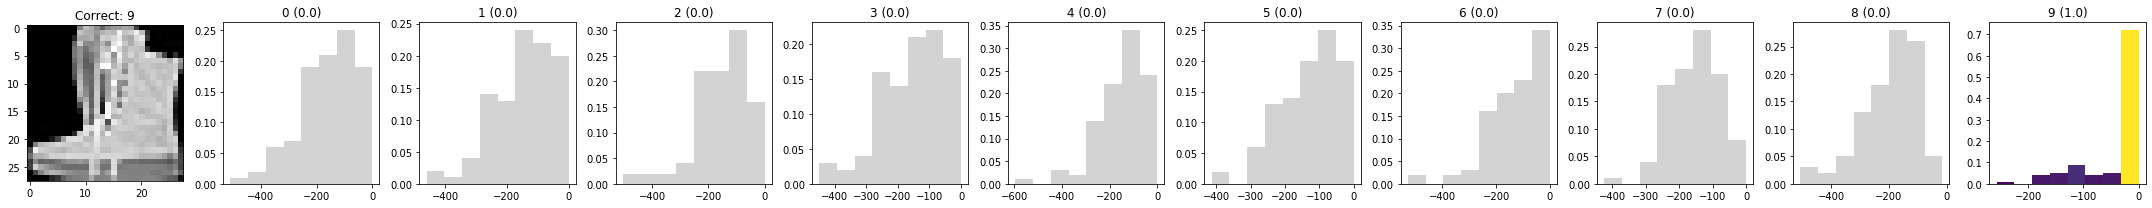

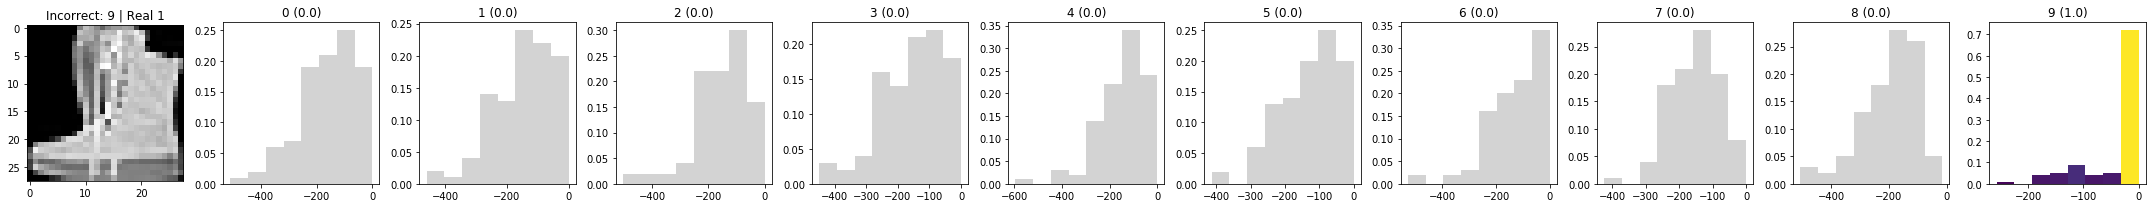

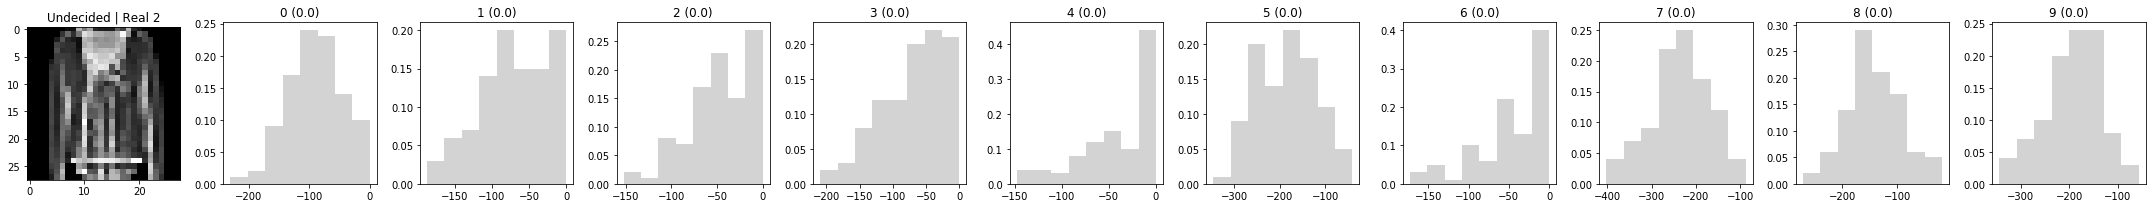

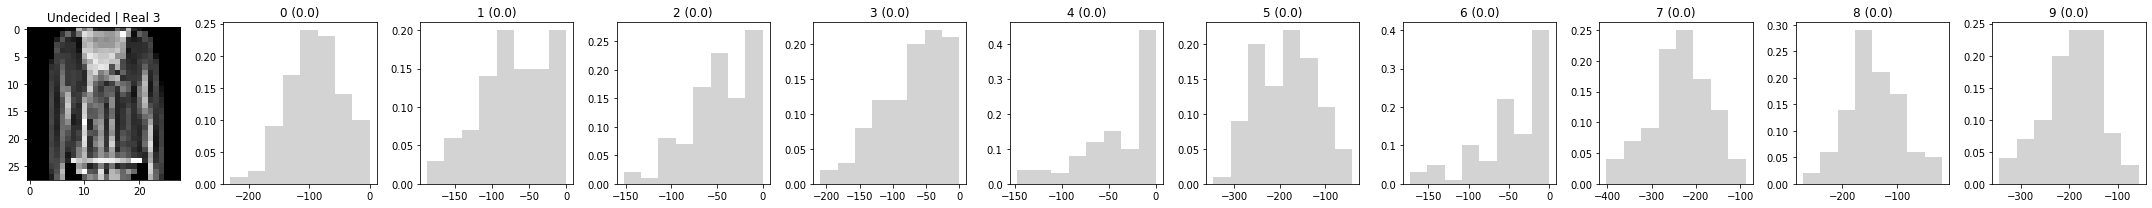


Summary
Total images:  10
Predicted for:  2
Accuracy when predicted: 1.0/2


(10, 1.0, 2)

In [35]:
test_batch(sum_imgs, sum_labs)

## References

[1] https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd